[View in Colaboratory](https://colab.research.google.com/github/kundajelab/ssvmimp/blob/master/lsgkmexplain.ipynb)

In [1]:
!rm -r lsgkm
!git clone https://github.com/kundajelab/lsgkm.git lsgkm
%cd lsgkm/src
!make
%cd ../..

rm: cannot remove 'lsgkm': No such file or directory
Cloning into 'lsgkm'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 198 (delta 52), reused 53 (delta 27), pack-reused 111
Receiving objects: 100% (198/198), 426.47 KiB | 9.27 MiB/s, done.
Resolving deltas: 100% (117/117), done.
/content/lsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
libsvm_gkm.c: In function ‘void kmertree_dfs_withhypexplanation(const KmerTree*, int, int, int, const BaseMismatchCountForExplanation*, int, int**, double***, int*)’:
libsvm_gkm.c:615:65: warning: ‘mmprof_mmcnt’ may be used uninitialized in this function [-Wmaybe-uninitialized]
                                     mmprof_mmcnt[data[i].seqid] += (data[i].wt*currbase_wt);
                                     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~
g++ -Wall -Wconversion -O3 -fPIC g

In [2]:
!pip install deeplift #for visualization

  Running setup.py bdist_wheel for deeplift ... - done
  Stored in directory: /root/.cache/pip/wheels/de/c4/b0/ec9deaa25dfaad60ad234f1d17b0339a8a9f5bfe4d7de42edd
Successfully built deeplift


In [8]:
!lsgkm/src/gkmexplain -m 0 lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.fa lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.explain.txt

INFO 2018-10-06 06:03:35: Number of threads is set to 1
INFO 2018-10-06 06:03:35: load model lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt
INFO 2018-10-06 06:03:35: write prediction result to lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.explain.txt
INFO 2018-10-06 06:03:41: 69 scored


In [9]:
!head lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.model.txt

svm_type c_svc
kernel_type gkm_esttrunc
L 10
k 6
d 3
nr_class 2
total_sv 958
rho 0.379216
label 1 -1
nr_sv 435 523


In [0]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.fa"))
              if i%2==1]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])
#read in the importance scores
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.explain.txt")
]

#read in the hyp importance scores
hypimpscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("lsgkm/tests/wgEncodeSydhTfbsGm12878Nfe2hStdAlnRep0.test.hypexplain.txt")
]

0.8714090764


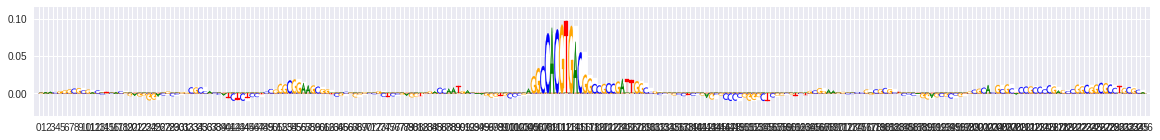

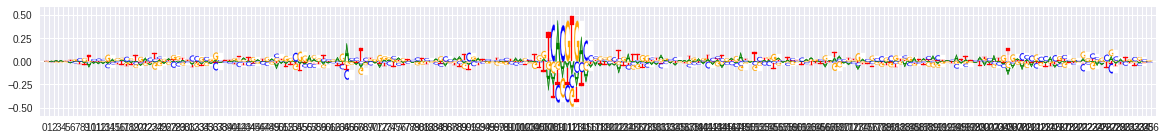

0.49278370521000014


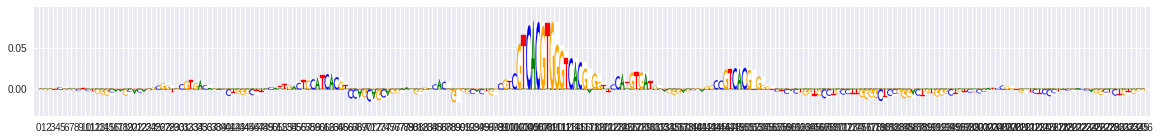

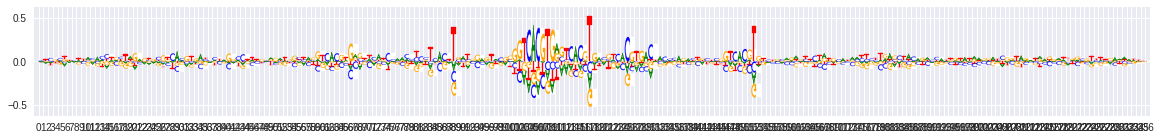

0.36159730199999995


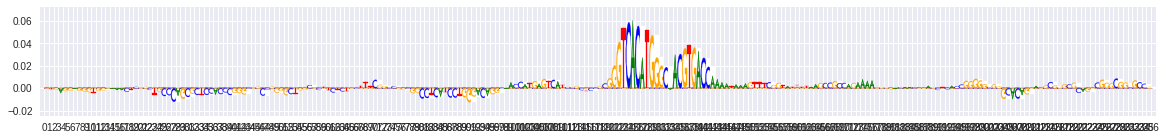

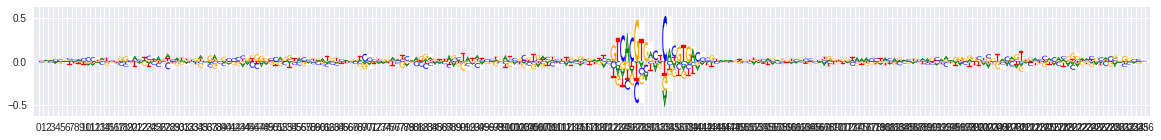

-0.0734240638


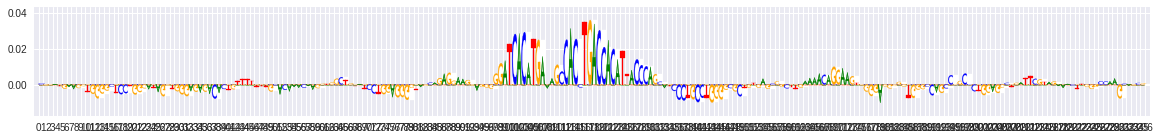

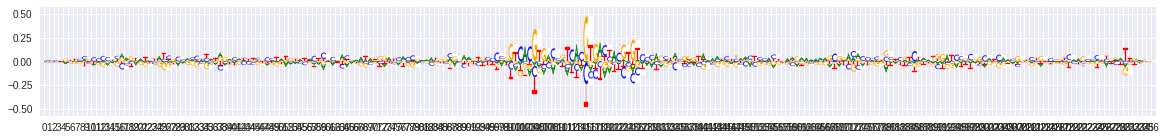

0.8780292366999998


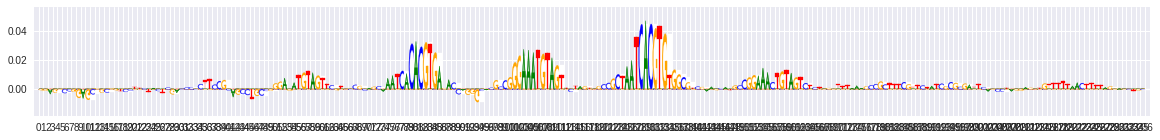

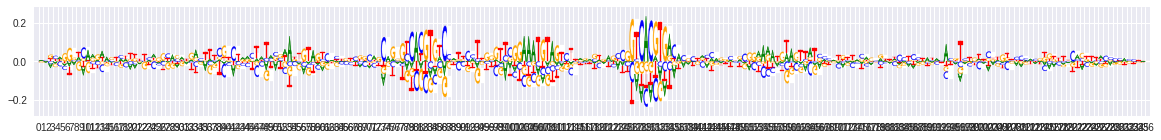

2.0558834311300003


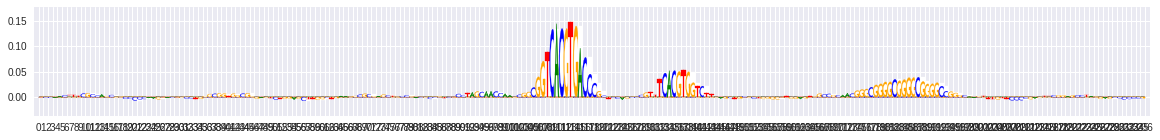

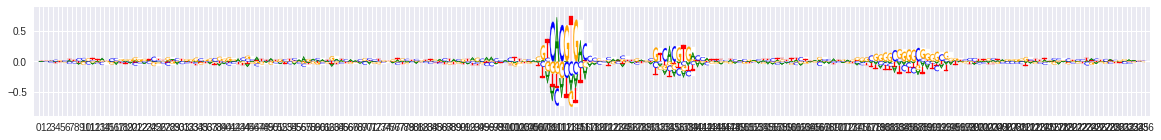

1.7913296632


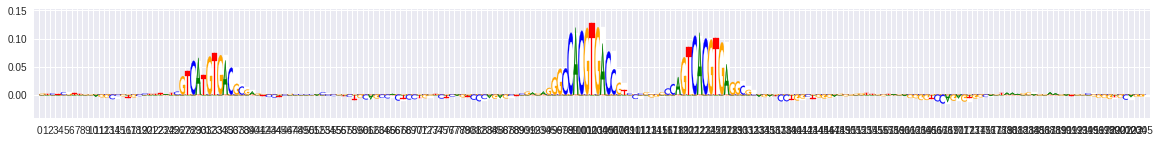

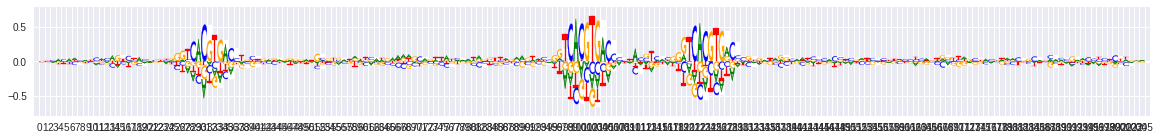

0.9232300379000002


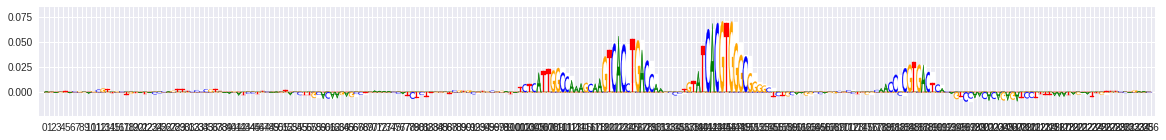

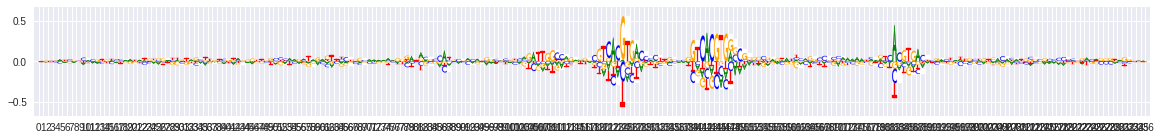

0.43344680150000003


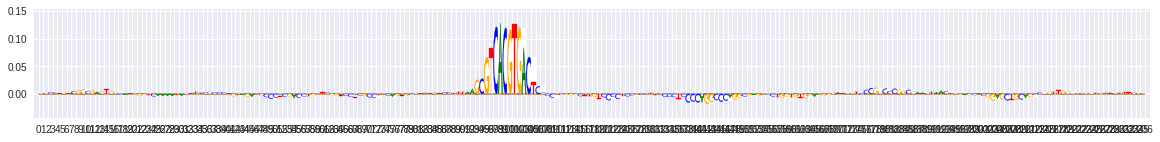

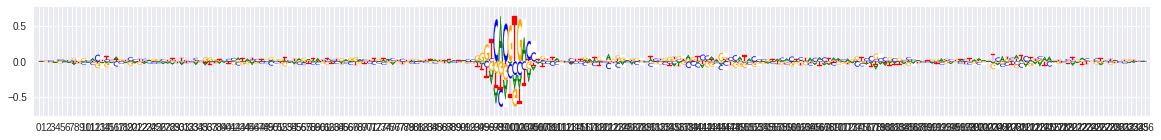

1.9475318665999999


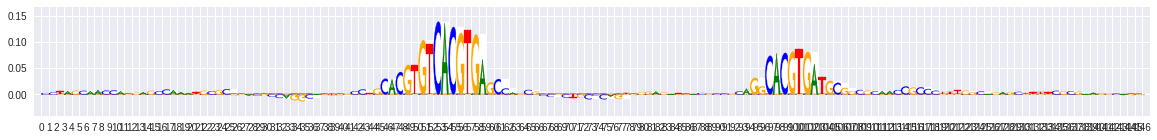

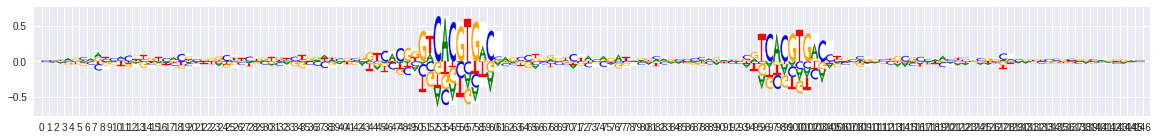

In [13]:
from deeplift.visualization import viz_sequence
for i in range(10):
  print(np.sum(impscores[i]) - 0.379216)
  viz_sequence.plot_weights(impscores[i])
  viz_sequence.plot_weights(hypimpscores[i]-np.mean(hypimpscores[i],axis=1)[:,None])
  assert np.max(np.abs(onehot_data[i]*hypimpscores[i] - impscores[i])) == 0